# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.head(12))
azdias.info()


    AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         -1                     2          1            2.0   
1         -1                     1          2            5.0   
2         -1                     3          2            3.0   
3          2                     4          2            2.0   
4         -1                     3          1            5.0   
5          3                     1          2            2.0   
6         -1                     2          2            5.0   
7         -1                     1          1            3.0   
8         -1                     3          1            3.0   
9         -1                     3          2            4.0   
10         0                     3          2            1.0   
11        -1                     2          1            6.0   

    FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                   3              4                 3               5   
1                  

In [4]:
feat_info.info()
feat_info[:5]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
for f in range(len(feat_info)): 
    missing_or_unknown_values = feat_info.iloc[f]['missing_or_unknown'] 
    missing_or_unknown_values = missing_or_unknown_values.strip(']') 
    missing_or_unknown_values = missing_or_unknown_values.strip('[') 
    missing_or_unknown_values = missing_or_unknown_values.split(sep=',') 
    missing_or_unknown_values = [int(value) if (value!='' and value!='X' and value!='XX') else value for value in missing_or_unknown_values] 
    if missing_or_unknown_values != ['']:
        azdias = azdias.replace({feat_info.iloc[f]['attribute']: missing_or_unknown_values}, np.nan)


In [6]:
print(azdias.head(12))

    AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        NaN                   2.0          1            2.0   
1        NaN                   1.0          2            5.0   
2        NaN                   3.0          2            3.0   
3        2.0                   4.0          2            2.0   
4        NaN                   3.0          1            5.0   
5        3.0                   1.0          2            2.0   
6        NaN                   2.0          2            5.0   
7        NaN                   1.0          1            3.0   
8        NaN                   3.0          1            3.0   
9        NaN                   3.0          2            4.0   
10       NaN                   3.0          2            1.0   
11       NaN                   2.0          1            6.0   

    FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                   3              4                 3               5   
1                  

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias.info()
null_columns=azdias.columns[azdias.isnull().any()]
print(azdias[null_columns].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

In [8]:
len(null_columns)

61

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
CJT_GESAMTTYP              4854
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SHOPPER_TYP              111196
SOHO_KZ                   73499
TITEL_KZ                 889061
VERS_TYP                 111196
ALTER_HH                 310267
ANZ_PERSONEN              73499
ANZ_TITEL                 73499
HH_EINKOMMEN_SCORE        18348
KK_KUNDENTYP             584612
W_KEIT_KIND_HH           147988
WOHNDAUER_2008            73499
ANZ_HAUSHALTE_AKTIV       99611
ANZ_HH_TITEL              97008
GEBAEUDETYP               93148
KONSUMNAEHE               73969
                          ...  
OST_WEST

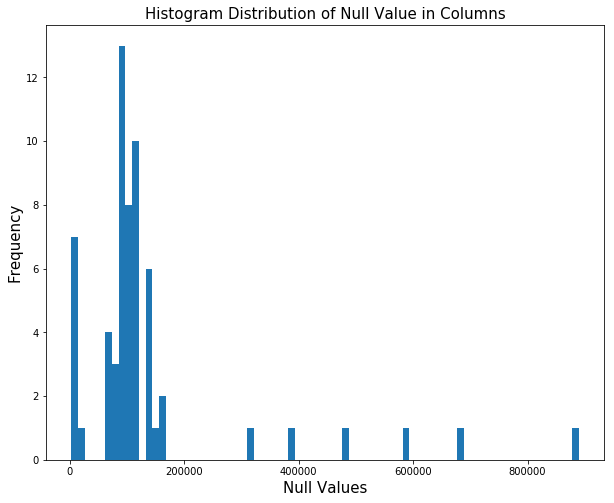

In [9]:
# Investigate patterns in the amount of missing data in each column.
azdias_null_columns = azdias[null_columns].isnull().sum()
print(azdias_null_columns )
print(azdias_null_columns.dtype)

plt.figure(figsize=[10,8])
plt.xlabel('Null Values',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Histogram Distribution of Null Value in Columns',fontsize=15)
plt.hist(azdias_null_columns, bins ='auto' )
plt.show()

In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
removed_azdias_outliers = azdias[azdias.columns[azdias.isnull().sum() < 200000]]
removed_azdias_outliers.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

#### Discussion 1.1.2: Assess Missing Data in Each Column

(The datasets shows that 61 out of 85 columns has at least one null value and the histogram further shows that most of the column has less than 200,000 null values. We removed the columns that has more than 200,000 null values from the dataset as outliers as they are clearly seperated from the remaining data points)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

0         43
3          7
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
20        10
23         8
24        47
25         5
26        19
29         2
30        34
34         4
35        43
39         5
40         4
42         2
46        40
48        47
53        43
54        47
60         4
61        43
62        43
64         5
          ..
891129     8
891130    34
891135     6
891136     2
891137    34
891139     7
891140    34
891150     3
891154    11
891155     4
891157     4
891159    43
891161     3
891162     6
891164    43
891169    18
891170    19
891171    34
891172    16
891173    19
891175    47
891181     3
891184     8
891185    47
891187    47
891203    14
891208     3
891216     3
891217     4
891218     5
Length: 268012, dtype: int64


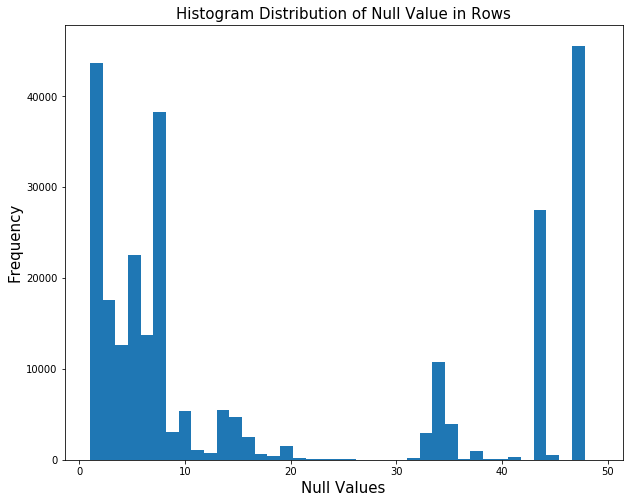

In [11]:
# How much data is missing in each row of the dataset?
index_with_nan =removed_azdias_outliers[removed_azdias_outliers.isnull().any(axis=1)]
sum_of_index_with_nan= index_with_nan.isnull().sum(axis=1)
print(sum_of_index_with_nan)

plt.figure(figsize=[10,8])
plt.xlabel('Null Values',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Histogram Distribution of Null Value in Rows',fontsize=15)
plt.hist(sum_of_index_with_nan, bins ='auto' )
plt.show()




In [12]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
nan_index_above_30 = removed_azdias_outliers[removed_azdias_outliers.isnull().sum(axis=1)>30]
nan_index_below_30 = removed_azdias_outliers[removed_azdias_outliers.isnull().sum(axis=1)<30]


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


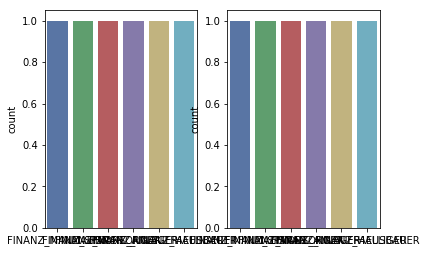

In [13]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

fig, ax =plt.subplots(1,2)
sns.set(rc={'axes.labelsize':8,
            'figure.figsize':(20.0, 10.0),
            'xtick.labelsize':8,
            'ytick.labelsize':10})

sns.countplot(nan_index_above_30.columns[3:9], ax=ax[0])
sns.countplot(nan_index_below_30.columns[3:9], ax=ax[1])
fig.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row
We noticed that majority of the rows have total null values less than 30 and this is the basis for division into two groups. The histogram also shows no qualitative difference between data with lots of missing values and data with few or no missing values


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [14]:
# How many features are there of each data type?
feat_info.info()
feat_info.head(10)
condition_1 = feat_info["type"] == 'numeric'
condition_2 = feat_info["type"] == 'ordinal'
condition_3 = feat_info["type"] == 'categorical'
condition_4 = feat_info["type"] == 'mixed'
print("number of numeric features is {}".format(len(feat_info[condition_1])))
print("number of ordinal features is {}".format(len(feat_info[condition_2])))
print("number of categorical features is {}".format(len(feat_info[condition_3])))
print("number of mixed features is {}".format(len(feat_info[condition_4])))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB
number of numeric features is 7
number of ordinal features is 49
number of categorical features is 21
number of mixed features is 7


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [15]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
category_columns = feat_info[feat_info["type"] == 'categorical']
list_of_categorical_columns = category_columns['attribute'].values.tolist()

#remove categorical columns that has been removed in Step 1.1.2 and 1.1.3
list_of_categorical_columns.remove('AGER_TYP')
list_of_categorical_columns.remove('TITEL_KZ')
list_of_categorical_columns.remove('KK_KUNDENTYP') 
categorical_columns=nan_index_below_30[list_of_categorical_columns]

# drop multi-level categorical  column
categorical_columns = categorical_columns.drop(['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP','LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB','ZABEOTYP', 'CAMEO_DEUG_2015',"NATIONALITAET_KZ",'SHOPPER_TYP'], axis=1)
nan_index_below_30 = nan_index_below_30.drop(['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP','LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB','ZABEOTYP', 'CAMEO_DEUG_2015',"NATIONALITAET_KZ",'SHOPPER_TYP'], axis=1)

In [16]:
categorical_columns
categorical_columns_1=categorical_columns.OST_WEST_KZ
categorical_columns_2=categorical_columns.CAMEO_DEU_2015
categorical_columns_3 = categorical_columns.VERS_TYP

In [17]:
nan_index_below_30 = nan_index_below_30.drop(categorical_columns.columns, axis=1)
print(nan_index_below_30)
del categorical_columns['OST_WEST_KZ']
del categorical_columns['CAMEO_DEU_2015']
del categorical_columns['VERS_TYP']




        ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                        1.0                  1              5   
2                        3.0                  1              4   
3                        4.0                  4              2   
4                        3.0                  4              3   
5                        1.0                  3              1   
6                        2.0                  1              5   
7                        1.0                  3              3   
8                        3.0                  4              4   
9                        3.0                  2              4   
10                       3.0                  2              2   
12                       3.0                  5              3   
13                       1.0                  1              4   
15                       4.0                  4              1   
16                       1.0                  4              3   
18        

In [18]:
# One-Hot Encode the remaining features in categorical_columns
categorical_columns = pd.get_dummies(data=categorical_columns, columns=['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'GEBAEUDETYP'])
categorical_columns_1= pd.get_dummies(data = categorical_columns_1, columns = ['OST_WEST_KZ'])
categorical_columns_2 = pd.get_dummies(data = categorical_columns_2, columns = ['CAMEO_DEU_2015'])
categorical_columns_3 = pd.get_dummies(data = categorical_columns_3, columns = ['VERS_TYP'])


In [19]:
categorical_columns_1 = categorical_columns_1.rename(columns={'O': 'OST_WEST_KZ_O', 'W': 'OST_WEST_KZ_W'})
categorical_columns_3 =categorical_columns_3.rename(columns={1.0: 'VERS_TYP_1.0', 2.0: 'VERS_TYP_2.0'})

In [20]:
nan_index_below_30 = pd.concat([nan_index_below_30,categorical_columns,categorical_columns_1,categorical_columns_3], axis=1)
nan_index_below_30.info()
print(nan_index_below_30)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798061 entries, 1 to 891220
Data columns (total 78 columns):
ALTERSKATEGORIE_GROB     795258 non-null float64
FINANZ_MINIMALIST        798061 non-null int64
FINANZ_SPARER            798061 non-null int64
FINANZ_VORSORGER         798061 non-null int64
FINANZ_ANLEGER           798061 non-null int64
FINANZ_UNAUFFAELLIGER    798061 non-null int64
FINANZ_HAUSBAUER         798061 non-null int64
HEALTH_TYP               761340 non-null float64
LP_LEBENSPHASE_FEIN      747828 non-null float64
LP_LEBENSPHASE_GROB      750721 non-null float64
PRAEGENDE_JUGENDJAHRE    769306 non-null float64
RETOURTYP_BK_S           793316 non-null float64
SEMIO_SOZ                798061 non-null int64
SEMIO_FAM                798061 non-null int64
SEMIO_REL                798061 non-null int64
SEMIO_MAT                798061 non-null int64
SEMIO_VERT               798061 non-null int64
SEMIO_LUST               798061 non-null int64
SEMIO_ERL                798061

#### Discussion 1.2.1: Re-Encode Categorical Features

The categorical columns consist of various columns with a lot of multilevel categoricals. Fourteen columns were dropped and one multilevel categorical column was not dropped. Multiple dummy variable (One-Hot Encoder) was used to create various multiple dummy variable on the existing columns

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [21]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
mixed_columns = feat_info[feat_info["type"] == 'mixed']
list_of_mixed_columns = mixed_columns['attribute'].values.tolist()
list_of_mixed_columns.remove('KBA05_BAUMAX')
mixed_columns=nan_index_below_30[list_of_mixed_columns]
nan_index_below_30 = nan_index_below_30.drop(mixed_columns.columns, axis=1)
print(mixed_columns)

        LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  PRAEGENDE_JUGENDJAHRE  \
1                      21.0                  6.0                   14.0   
2                       3.0                  1.0                   15.0   
3                       NaN                  NaN                    8.0   
4                      32.0                 10.0                    8.0   
5                       8.0                  2.0                    3.0   
6                       2.0                  1.0                   10.0   
7                       5.0                  2.0                    8.0   
8                      10.0                  3.0                   11.0   
9                       4.0                  1.0                   15.0   
10                      6.0                  2.0                    3.0   
12                     23.0                  6.0                    8.0   
13                      3.0                  1.0                   15.0   
15                     12

In [22]:
mixed_null_columns=mixed_columns.columns[mixed_columns.isnull().any()]
mixed_columns[mixed_null_columns].isnull().sum()

LP_LEBENSPHASE_FEIN      50233
LP_LEBENSPHASE_GROB      47340
PRAEGENDE_JUGENDJAHRE    28755
CAMEO_INTL_2015           6198
PLZ8_BAUMAX              23355
dtype: int64

In [23]:
m = mixed_columns[mixed_null_columns].isnull().sum()/len(nan_index_below_30)
print(m*100)

LP_LEBENSPHASE_FEIN      6.294381
LP_LEBENSPHASE_GROB      5.931877
PRAEGENDE_JUGENDJAHRE    3.603108
CAMEO_INTL_2015          0.776632
PLZ8_BAUMAX              2.926468
dtype: float64


In [24]:
mixed_columns['PRAEGENDE_JUGENDJAHRE_AGE']= mixed_columns['PRAEGENDE_JUGENDJAHRE'].map({'Null':'Null',-1.0:'Null', 0.0:'Null', 1.0:40, 2.0:40, 3.0:50, 4.0:50, 5.0:60, 6.0:60, 7.0:60, 8.0:70, 9.0:70, 10.0:80, 11.0:80, 12.0:80, 13.0:80, 14.0:90, 15:90})
mixed_columns['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = mixed_columns['PRAEGENDE_JUGENDJAHRE'].map({'Null':'Null',-1.0:'Null', 0.0:'Null', 1.0:1, 2.0:0, 3.0:1, 4.0:0, 5.0:1, 6.0:0, 7.0:0, 8.0:1, 9.0:0, 10.0:1, 11.0:0, 12.0:1, 13.0:0, 14.0:1, 15:0})
mixed_columns[['PRAEGENDE_JUGENDJAHRE', 'PRAEGENDE_JUGENDJAHRE_AGE','PRAEGENDE_JUGENDJAHRE_MOVEMENT']] 
del (mixed_columns['PRAEGENDE_JUGENDJAHRE'])
print(mixed_columns)

        LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  WOHNLAGE CAMEO_INTL_2015  \
1                      21.0                  6.0       4.0              51   
2                       3.0                  1.0       2.0              24   
3                       NaN                  NaN       7.0              12   
4                      32.0                 10.0       3.0              43   
5                       8.0                  2.0       7.0              54   
6                       2.0                  1.0       5.0              22   
7                       5.0                  2.0       1.0              14   
8                      10.0                  3.0       1.0              13   
9                       4.0                  1.0       7.0              15   
10                      6.0                  2.0       5.0              51   
12                     23.0                  6.0       3.0              43   
13                      3.0                  1.0       5.0      

In [25]:
mixed_columns = pd.get_dummies(data=mixed_columns, columns=['PRAEGENDE_JUGENDJAHRE_MOVEMENT'])
print(mixed_columns)

        LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  WOHNLAGE CAMEO_INTL_2015  \
1                      21.0                  6.0       4.0              51   
2                       3.0                  1.0       2.0              24   
3                       NaN                  NaN       7.0              12   
4                      32.0                 10.0       3.0              43   
5                       8.0                  2.0       7.0              54   
6                       2.0                  1.0       5.0              22   
7                       5.0                  2.0       1.0              14   
8                      10.0                  3.0       1.0              13   
9                       4.0                  1.0       7.0              15   
10                      6.0                  2.0       5.0              51   
12                     23.0                  6.0       3.0              43   
13                      3.0                  1.0       5.0      

In [26]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
mixed_columns["CAMEO_INTL_2015" ].dtype
mixed_columns["CAMEO_INTL_2015" ] = mixed_columns["CAMEO_INTL_2015" ].astype(str)
mixed_columns["CAMEO_INTL_2015_FIRST" ] = mixed_columns["CAMEO_INTL_2015" ].str[0]
mixed_columns["CAMEO_INTL_2015_SECOND" ] = mixed_columns["CAMEO_INTL_2015" ].str[1]
mixed_columns["CAMEO_INTL_2015_FIRST" ].dtype
del (mixed_columns['CAMEO_INTL_2015'])

In [27]:
dropped_mixed_columns =['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX']
mixed_columns =mixed_columns.drop(dropped_mixed_columns, axis=1)
print(mixed_columns)


       PRAEGENDE_JUGENDJAHRE_AGE  PRAEGENDE_JUGENDJAHRE_MOVEMENT_0  \
1                             90                                 0   
2                             90                                 1   
3                             70                                 0   
4                             70                                 0   
5                             50                                 0   
6                             80                                 0   
7                             70                                 0   
8                             80                                 1   
9                             90                                 1   
10                            50                                 0   
12                            70                                 0   
13                            90                                 1   
15                            60                                 0   
16                  

In [28]:
nan_index_below_30 = pd.concat([nan_index_below_30, mixed_columns], axis=1)

In [29]:
print(nan_index_below_30)

        ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                        1.0                  1              5   
2                        3.0                  1              4   
3                        4.0                  4              2   
4                        3.0                  4              3   
5                        1.0                  3              1   
6                        2.0                  1              5   
7                        1.0                  3              3   
8                        3.0                  4              4   
9                        3.0                  2              4   
10                       3.0                  2              2   
12                       3.0                  5              3   
13                       1.0                  1              4   
15                       4.0                  4              1   
16                       1.0                  4              3   
18        

#### Discussion 1.2.2: Engineer Mixed-Type Features

(For the mixed features, I decided to keep the two engineered columns that we were instructed to work on, the rest were dropped)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [30]:
def clean_dataa(df):
    for f in range(len(feat_info)): 
        missing_or_unknown_values = feat_info.iloc[f]['missing_or_unknown'] 
        missing_or_unknown_values = missing_or_unknown_values.strip(']') 
        missing_or_unknown_values = missing_or_unknown_values.strip('[') 
        missing_or_unknown_values = missing_or_unknown_values.split(sep=',') 
        missing_or_unknown_values = [int(value) if (value!='' and value!='X' and value!='XX') else value for value in missing_or_unknown_values] 
    if missing_or_unknown_values != ['']:
        df = df.replace({feat_info.iloc[f]['attribute']: missing_or_unknown_values}, np.nan)

    # Remove the outlier columns from the dataset
    removed_df_outliers = df[df.columns[df.isnull().sum() < 200000]]

    # Write code to divide the data into two subsets based on the number of missing rows
    null_index_above_30= removed_df_outliers[removed_df_outliers.isnull().sum(axis=1)>30]
    null_index_below_30= removed_df_outliers[removed_df_outliers.isnull().sum(axis=1)<30]

    category_columns = feat_info[feat_info["type"] == 'categorical']
    list_of_categorical_columns = category_columns['attribute'].values.tolist()
    list_of_categorical_columns.remove('AGER_TYP')
    list_of_categorical_columns.remove('TITEL_KZ')
    list_of_categorical_columns.remove('KK_KUNDENTYP')
    categorical_columns=null_index_below_30[list_of_categorical_columns]

    # drop multi-level categorical  column
    categorical_columns = categorical_columns.drop(['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP','LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB','ZABEOTYP', 'CAMEO_DEUG_2015',"NATIONALITAET_KZ",'SHOPPER_TYP'], axis=1)
    null_index_below_30 = null_index_below_30.drop(['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP','LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB','ZABEOTYP', 'CAMEO_DEUG_2015',"NATIONALITAET_KZ",'SHOPPER_TYP'], axis=1)

    categorical_columns_1=categorical_columns.OST_WEST_KZ
    categorical_columns_2=categorical_columns.CAMEO_DEU_2015
    categorical_columns_3 = categorical_columns.VERS_TYP

    null_index_below_30 = null_index_below_30.drop(categorical_columns.columns, axis=1)
    del categorical_columns['OST_WEST_KZ']
    del categorical_columns['CAMEO_DEU_2015']
    del categorical_columns['VERS_TYP']


    # One-Hot Encode the remaining features in categorical_columns
    categorical_columns = pd.get_dummies(data=categorical_columns, columns=['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'GEBAEUDETYP'])
    categorical_columns_1= pd.get_dummies(data = categorical_columns_1, columns = ['OST_WEST_KZ'])
    categorical_columns_2 = pd.get_dummies(data = categorical_columns_2, columns = ['CAMEO_DEU_2015'])
    categorical_columns_3 = pd.get_dummies(data = categorical_columns_3, columns = ['VERS_TYP'])

    categorical_columns_1 = categorical_columns_1.rename(columns={'O': 'OST_WEST_KZ_O', 'W': 'OST_WEST_KZ_W'})
    categorical_columns_3 =categorical_columns_3.rename(columns={1.0: 'VERS_TYP_1.0', 2.0: 'VERS_TYP_2.0'})

    #Add the encoded features to the null_index_below_30 dataset
    null_index_below_30 = pd.concat([null_index_below_30,categorical_columns,categorical_columns_1,categorical_columns_3], axis=1)

    mixed_columns = feat_info[feat_info["type"] == 'mixed']
    list_of_mixed_columns = mixed_columns['attribute'].values.tolist()
    list_of_mixed_columns.remove('KBA05_BAUMAX')
    mixed_columns=null_index_below_30[list_of_mixed_columns]
    null_index_below_30 = null_index_below_30.drop(mixed_columns.columns, axis=1)

    mixed_columns['PRAEGENDE_JUGENDJAHRE_AGE']= mixed_columns['PRAEGENDE_JUGENDJAHRE'].map({'Null':np.NaN,-1.0:np.NaN, 0.0:np.NaN, 1.0:40, 2.0:40, 3.0:50, 4.0:50, 5.0:60, 6.0:60, 7.0:60, 8.0:70, 9.0:70, 10.0:80, 11.0:80, 12.0:80, 13.0:80, 14.0:90, 15:90})
    mixed_columns['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = mixed_columns['PRAEGENDE_JUGENDJAHRE'].map({'Null':np.NaN,-1.0:np.NaN, 0.0:np.NaN, 1.0:1, 2.0:0, 3.0:1, 4.0:0, 5.0:1, 6.0:0, 7.0:0, 8.0:1, 9.0:0, 10.0:1, 11.0:0, 12.0:1, 13.0:0, 14.0:1, 15:0})
    mixed_columns[['PRAEGENDE_JUGENDJAHRE', 'PRAEGENDE_JUGENDJAHRE_AGE','PRAEGENDE_JUGENDJAHRE_MOVEMENT']] 
    del (mixed_columns['PRAEGENDE_JUGENDJAHRE'])
    
    mixed_columns = pd.get_dummies(data=mixed_columns, columns=['PRAEGENDE_JUGENDJAHRE_MOVEMENT'])

    mixed_columns["CAMEO_INTL_2015" ] = mixed_columns["CAMEO_INTL_2015" ].astype(str)
    mixed_columns["CAMEO_INTL_2015_FIRST" ] = mixed_columns["CAMEO_INTL_2015" ].str[0]
    mixed_columns["CAMEO_INTL_2015_SECOND" ] = mixed_columns["CAMEO_INTL_2015" ].str[1]
    del (mixed_columns['CAMEO_INTL_2015'])

    dropped_mixed_columns =['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX']
    mixed_columns =mixed_columns.drop(dropped_mixed_columns, axis=1)
    null_index_below_30 = pd.concat([null_index_below_30, mixed_columns], axis=1)
    
    null_index_below_30['PRAEGENDE_JUGENDJAHRE_AGE'] = null_index_below_30['PRAEGENDE_JUGENDJAHRE_AGE'].astype(float)
    null_index_below_30['CAMEO_INTL_2015_FIRST'] = pd.to_numeric(null_index_below_30['CAMEO_INTL_2015_FIRST'], errors='coerce')
    null_index_below_30['CAMEO_INTL_2015_FIRST']= null_index_below_30['CAMEO_INTL_2015_FIRST'].replace(np.nan, 0, regex=True)
    null_index_below_30['CAMEO_INTL_2015_SECOND'] = pd.to_numeric(null_index_below_30['CAMEO_INTL_2015_SECOND'], errors='coerce')
    null_index_below_30['CAMEO_INTL_2015_SECOND']= null_index_below_30['CAMEO_INTL_2015_SECOND'].replace(np.nan, 0, regex=True)
    
    dropped_columns =['AGER_TYP','TITEL_KZ','KK_KUNDENTYP','ALTER_HH','GEBURTSJAHR', -1]
    null_index_below_30 = null_index_below_30.drop(dropped_columns, axis=1)
    
    return null_index_below_30

In [31]:
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [32]:
cleaned_customers = clean_dataa(customers)

In [33]:
cleaned_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141722 entries, 0 to 191651
Data columns (total 77 columns):
ALTERSKATEGORIE_GROB                  141722 non-null int64
FINANZ_MINIMALIST                     141722 non-null int64
FINANZ_SPARER                         141722 non-null int64
FINANZ_VORSORGER                      141722 non-null int64
FINANZ_ANLEGER                        141722 non-null int64
FINANZ_UNAUFFAELLIGER                 141722 non-null int64
FINANZ_HAUSBAUER                      141722 non-null int64
HEALTH_TYP                            141722 non-null int64
RETOURTYP_BK_S                        138601 non-null float64
SEMIO_SOZ                             141722 non-null int64
SEMIO_FAM                             141722 non-null int64
SEMIO_REL                             141722 non-null int64
SEMIO_MAT                             141722 non-null int64
SEMIO_VERT                            141722 non-null int64
SEMIO_LUST                            141722 no

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

##### If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.

In [34]:
#replaced non-numericals in Cameo_Intl_2015 with zero and converted to Numeric data type
nan_index_below_30['PRAEGENDE_JUGENDJAHRE_AGE'] = nan_index_below_30['PRAEGENDE_JUGENDJAHRE_AGE'].astype(float)
nan_index_below_30['CAMEO_INTL_2015_FIRST'] = pd.to_numeric(nan_index_below_30['CAMEO_INTL_2015_FIRST'], errors='coerce')
nan_index_below_30['CAMEO_INTL_2015_FIRST']= nan_index_below_30['CAMEO_INTL_2015_FIRST'].replace(np.nan, 0, regex=True)
nan_index_below_30['CAMEO_INTL_2015_SECOND'] = pd.to_numeric(nan_index_below_30['CAMEO_INTL_2015_SECOND'], errors='coerce')
nan_index_below_30['CAMEO_INTL_2015_SECOND']= nan_index_below_30['CAMEO_INTL_2015_SECOND'].replace(np.nan, 0, regex=True)
nan_index_below_30.dtypes

ALTERSKATEGORIE_GROB                float64
FINANZ_MINIMALIST                     int64
FINANZ_SPARER                         int64
FINANZ_VORSORGER                      int64
FINANZ_ANLEGER                        int64
FINANZ_UNAUFFAELLIGER                 int64
FINANZ_HAUSBAUER                      int64
HEALTH_TYP                          float64
RETOURTYP_BK_S                      float64
SEMIO_SOZ                             int64
SEMIO_FAM                             int64
SEMIO_REL                             int64
SEMIO_MAT                             int64
SEMIO_VERT                            int64
SEMIO_LUST                            int64
SEMIO_ERL                             int64
SEMIO_KULT                            int64
SEMIO_RAT                             int64
SEMIO_KRIT                            int64
SEMIO_DOM                             int64
SEMIO_KAEM                            int64
SEMIO_PFLICHT                         int64
SEMIO_TRADV                     

In [35]:
print(type(nan_index_below_30))
rejoined_columns = nan_index_below_30.columns
print(rejoined_columns)
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(nan_index_below_30)
nan_index_below_30= imputer.transform(nan_index_below_30)

<class 'pandas.core.frame.DataFrame'>
Index(['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT',
       'ORTSGR_KLS9', 'RELAT_AB', 'ANREDE_K

In [36]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaler.fit(nan_index_below_30)
scaled_nan_index_below_30 = scaler.transform(nan_index_below_30)

In [37]:
scaled_nan_index_below_30.shape

(798061, 77)

### Discussion 2.1: Apply Feature Scaling

(Feature scaling would not work on non_numerical data and this were discovered in the Cameo_Intl_2015 due to the splitting of Nan value.The non-numerical values were converted to zero.

Also, the standard scaler was used as instructed to scale the data)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [38]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.
    
    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform
           
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    X_pc = pca.fit_transform(data)
    return pca, X_pc
pca_object, reduced_nan_index_below_30 = do_pca(38,scaled_nan_index_below_30)



In [39]:
reduced_nan_index_below_30.shape

(798061, 38)

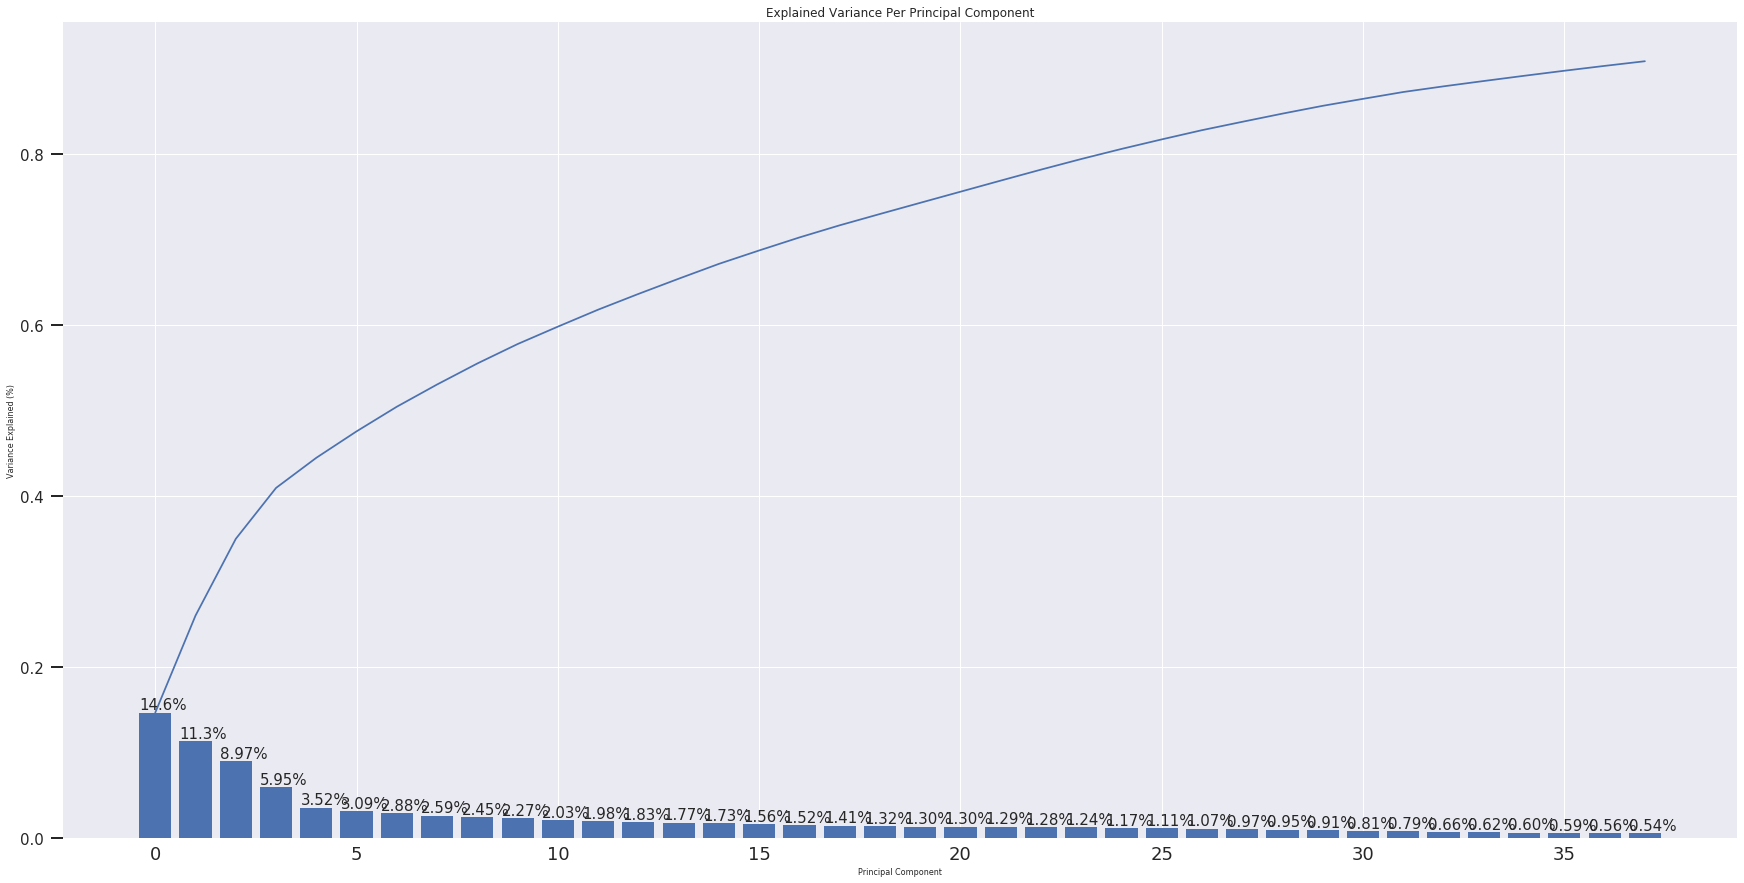

In [40]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca_object- the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca_object.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca_object.explained_variance_ratio_
 
    plt.figure(figsize=(30, 15))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=15)
 
    ax.xaxis.set_tick_params(width=50, labelsize=18)
    ax.yaxis.set_tick_params(width=2, length=12, labelsize=15)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca_object)

In [41]:
# Re-apply PCA to the data while selecting for number of components to retain
pca_object, reduced_nan_index_below_30 = do_pca(17,scaled_nan_index_below_30)

In [42]:
reduced_nan_index_below_30.shape

(798061, 17)

### Discussion 2.2: Perform Dimensionality Reduction

(From the visualization above, we noticed that 52.9% of the dataset has been explained by the first seven clusters. I retained 17 clusters which explained upto 82% of the dataset.)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [43]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
print(rejoined_columns)
print(len(rejoined_columns))
def print_component(pca_object, comp):
    if comp <= len(pca_object.components_):
        weight_df = pd.DataFrame({'weight': pca_object.components_[comp]}, index=rejoined_columns)
        print("Most wieghted features for the component ", comp)
        print(weight_df.sort_values(by=['weight']).head(5))
        print(weight_df.sort_values(by=['weight']).tail(5))
    else:
        print('That is not the right input, please read the docstring before continuing.')
        
print_component(pca_object, 0)



Index(['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT',
       'ORTSGR_KLS9', 'RELAT_AB', 'ANREDE_KZ_1', 'ANREDE_KZ_2',
       'GREEN_AVA

In [44]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_component(pca_object, 1)


Most wieghted features for the component  1
                             weight
SEMIO_REL                 -0.263863
SEMIO_KULT                -0.244556
PRAEGENDE_JUGENDJAHRE_AGE -0.242436
FINANZ_SPARER             -0.230144
SEMIO_TRADV               -0.223845
                        weight
RETOURTYP_BK_S        0.150434
SEMIO_LUST            0.178037
FINANZ_VORSORGER      0.225193
SEMIO_ERL             0.249111
ALTERSKATEGORIE_GROB  0.253536


In [45]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_component(pca_object, 2)


Most wieghted features for the component  2
               weight
ANREDE_KZ_2 -0.333293
SEMIO_KAEM  -0.295724
SEMIO_DOM   -0.276240
SEMIO_KRIT  -0.236786
SEMIO_RAT   -0.226137
               weight
SEMIO_KULT   0.187732
SEMIO_FAM    0.205499
SEMIO_SOZ    0.228067
SEMIO_VERT   0.310047
ANREDE_KZ_1  0.333293


### Discussion 2.3: Interpret Principal Components

(The interpretation of each components is explained by the correlations between the original data and each principal component.The further a weight is from zero, the more the principal component is in the direction of the corresponding feature.

For the first component(Component 0), It increases with a decreasing value of features like  Movement pattern,Number of 1-2 family houses in the microcell,Number of 1-2 family houses in the PLZ8 region, Number of building in the microcell and Financial typology- low financial interest.It also showed an increase when features like Wealth, Estimated Household Income,Number of 6-10 family houses in the PLZ8 region and Number of 10+ family houses in the PLZ8 region increases. 

In general the first component deals with the Number of Family Houses and Household income.

For the second component(Component 1), It increases with a decreasing features of Personality typology of being religious and cultural minded, and also the Dominating movement of person's youth in terms of decade. It also showed an increase with an increase in Estimated age of a person based on given name analysis and event-oriented.  

In general the second component deals with how Age and Personality correlate.

For the third component(Component 2), It increases with a decreasing features of Female Gender, Combative and Dominant Attitude.It also showed an increase with an increase in Male Gender and Dreamful attitude.

In general the second component deals with how the type of Gender correlate with Personality.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [46]:
reduced_nan_index_below_30=pd.DataFrame(reduced_nan_index_below_30)

# Over a number of different cluster counts...

# Over a number of different cluster counts... 
scores = []
for cluster in range(2, 10, 2):
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=cluster)
    model = kmeans.fit(reduced_nan_index_below_30)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(reduced_nan_index_below_30))
    scores.append(score)
    

    

In [47]:
x=2
print(x)

2


In [48]:
for cluster in range(10, 20, 2):
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=cluster)
    model = kmeans.fit(reduced_nan_index_below_30)
    
     # compute the average within-cluster distances.
    score_2 = np.abs(model.score(reduced_nan_index_below_30))
    scores.append(score_2)

In [49]:
for cluster in range(20, 28, 2):
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=cluster)
    model = kmeans.fit(reduced_nan_index_below_30)
    
     # compute the average within-cluster distances.
    score_3 = np.abs(model.score(reduced_nan_index_below_30))
    scores.append(score_3)

In [50]:
scores

[36391185.714560442,
 30693344.569660213,
 27358117.282015353,
 24945525.362120554,
 22856529.580883119,
 21574368.677469879,
 20968831.33530505,
 20189112.277874954,
 19526048.567744065,
 19224045.502672486,
 18565592.43353172,
 18249739.719059464,
 17867805.000272188]

Text(0,0.5,'Score')

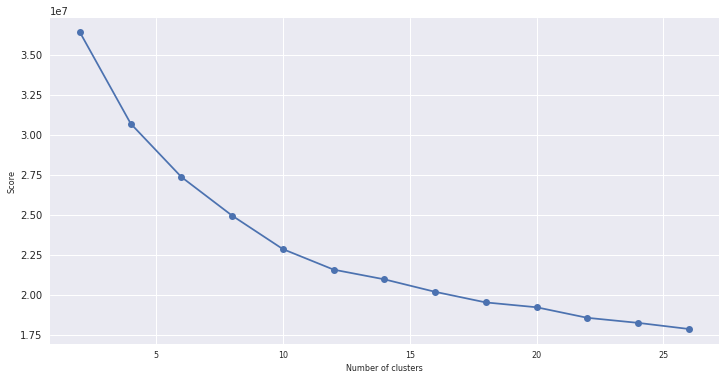

In [51]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

frame = pd.DataFrame({'Cluster':range(2,28,2), 'Score':scores})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['Score'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Score')


In [52]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=10, init='k-means++')
model = kmeans.fit(reduced_nan_index_below_30)
clustered_nan_index_below_30 = model.predict(reduced_nan_index_below_30)   


In [53]:
clustered_nan_index_below_30
clustered_nan_index_below_30.shape

(798061,)

### Discussion 3.1: Apply Clustering to General Population

(The average distance decreases with an increasing number of clusters as expected and this was shown by the further explained by the visualization. I choose 10 clusters because further from that point, there was a decrease in the distance became constant.)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [54]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [55]:
cleaned_customers=clean_dataa(customers)

In [56]:
cleaned_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141722 entries, 0 to 191651
Data columns (total 77 columns):
ALTERSKATEGORIE_GROB                  141722 non-null int64
FINANZ_MINIMALIST                     141722 non-null int64
FINANZ_SPARER                         141722 non-null int64
FINANZ_VORSORGER                      141722 non-null int64
FINANZ_ANLEGER                        141722 non-null int64
FINANZ_UNAUFFAELLIGER                 141722 non-null int64
FINANZ_HAUSBAUER                      141722 non-null int64
HEALTH_TYP                            141722 non-null int64
RETOURTYP_BK_S                        138601 non-null float64
SEMIO_SOZ                             141722 non-null int64
SEMIO_FAM                             141722 non-null int64
SEMIO_REL                             141722 non-null int64
SEMIO_MAT                             141722 non-null int64
SEMIO_VERT                            141722 non-null int64
SEMIO_LUST                            141722 no

In [57]:
column_customers = cleaned_customers.columns


In [58]:
column_customers

Index(['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'ANREDE_KZ_1', 'ANREDE_KZ_2',
 

In [59]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

imputer_customer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
cleaned_customers = imputer_customer.fit_transform(cleaned_customers )

scaled_cleaned_customers  = scaler.fit_transform(cleaned_customers)
scaled_cleaned_customers


array([[ 0.66037453,  0.72317643, -0.51702371, ..., -0.9885919 ,
        -1.12400727, -0.26061655],
       [ 0.66037453,  0.72317643, -0.51702371, ..., -0.9885919 ,
         0.2922265 ,  0.4769643 ],
       [ 0.66037453,  0.72317643, -0.51702371, ...,  1.01153974,
        -0.41589039,  0.4769643 ],
       ..., 
       [ 0.66037453,  0.72317643, -0.51702371, ..., -0.9885919 ,
        -0.41589039,  0.4769643 ],
       [-0.65012885, -2.22360413, -0.51702371, ...,  1.01153974,
        -0.41589039,  0.4769643 ],
       [-1.96063224,  0.72317643, -0.51702371, ...,  1.01153974,
         0.2922265 , -0.26061655]])

In [60]:
len(scaled_cleaned_customers)

141722

In [61]:
reduced_cleaned_customers = pca_object.transform(scaled_cleaned_customers)
clustered_cleaned_customers = model.predict(reduced_cleaned_customers)  

In [62]:
print(cleaned_customers[0:10])

[[  4.00000000e+00   5.00000000e+00   1.00000000e+00   5.00000000e+00
    1.00000000e+00   2.00000000e+00   2.00000000e+00   1.00000000e+00
    5.00000000e+00   6.00000000e+00   5.00000000e+00   2.00000000e+00
    6.00000000e+00   6.00000000e+00   7.00000000e+00   3.00000000e+00
    4.00000000e+00   1.00000000e+00   3.00000000e+00   1.00000000e+00
    1.00000000e+00   2.00000000e+00   1.00000000e+00   2.00000000e+00
    0.00000000e+00   1.00000000e+00   6.00000000e+00   9.00000000e+00
    1.00000000e+00   0.00000000e+00   5.00000000e+00   1.99200000e+03
    2.00000000e+00   2.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   4.00000000e+00   3.00000000e+00   2.00000000e+00
    4.00000000e+00   4.00000000e+00   1.00000000e+00   4.00000000e+00
    3.00000000e+00   1.00000000e+00   1.20100000e+03   3.00000000e+00
    3.00000000e+00   1.00000000e+00   0.00000000e+00   5.00000000e+00
    5.00000000e+00   1.00000000e+00   2.00000000e+00   1.00000000e+00
    1.00000000e+00  

In [63]:
clustered_cleaned_customers.shape

(141722,)

In [64]:
clustered_cleaned_customers= pd.DataFrame(clustered_cleaned_customers)
clustered_nan_index_below_30 = pd.DataFrame(clustered_nan_index_below_30)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [65]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
prop_customers = clustered_cleaned_customers[0].value_counts()
prop_dataset = clustered_nan_index_below_30[0].value_counts()

prop_customers = prop_customers/len(clustered_cleaned_customers)
prop_dataset = prop_dataset/len(clustered_nan_index_below_30)

prop_customers= prop_customers*100 
prop_dataset= prop_dataset*100

prop_customers = prop_customers.sort_index(ascending=True)
prop_dataset=prop_dataset.sort_index(ascending=True)

index_prop_customers= prop_customers.index.values
index_prop_dataset = prop_dataset.index.values

print(index_prop_customers)
print(prop_customers)
print(prop_dataset)

[0 1 2 3 4 5 6 7 9]
0    13.846121
1    11.960740
2    13.920210
3    25.841436
4     6.874021
5    16.765922
6     6.023765
7     0.167934
9     4.599850
Name: 0, dtype: float64
0    10.332544
1    12.001088
2    11.124212
3    14.424837
4    10.709708
5    12.201824
6     9.939215
7     8.007283
8     0.841665
9    10.417625
Name: 0, dtype: float64


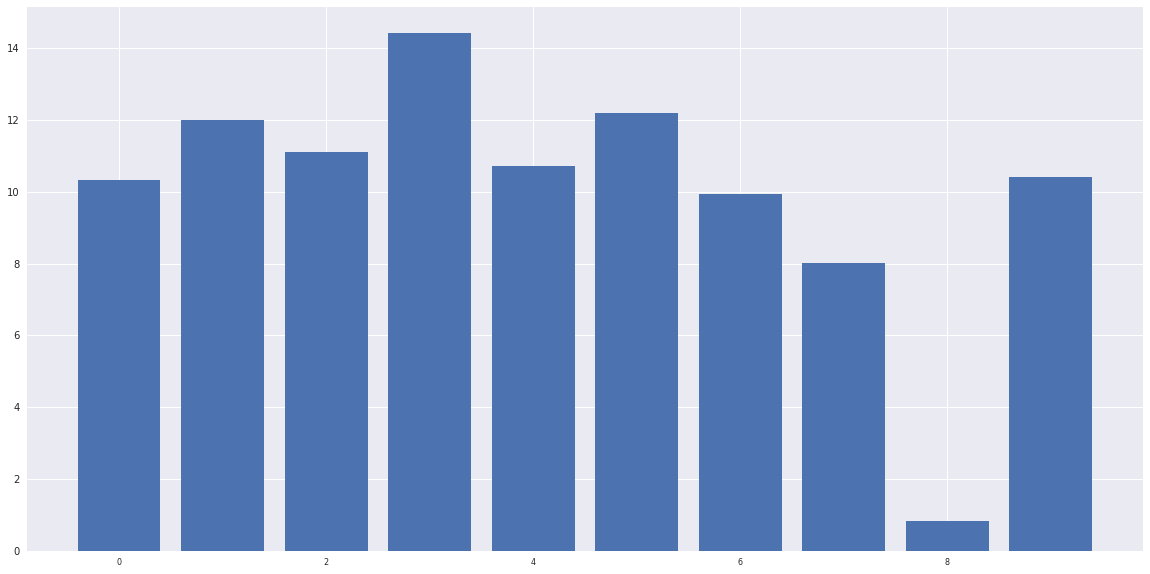

In [66]:
plt.bar(index_prop_dataset,prop_dataset)
plt.show()

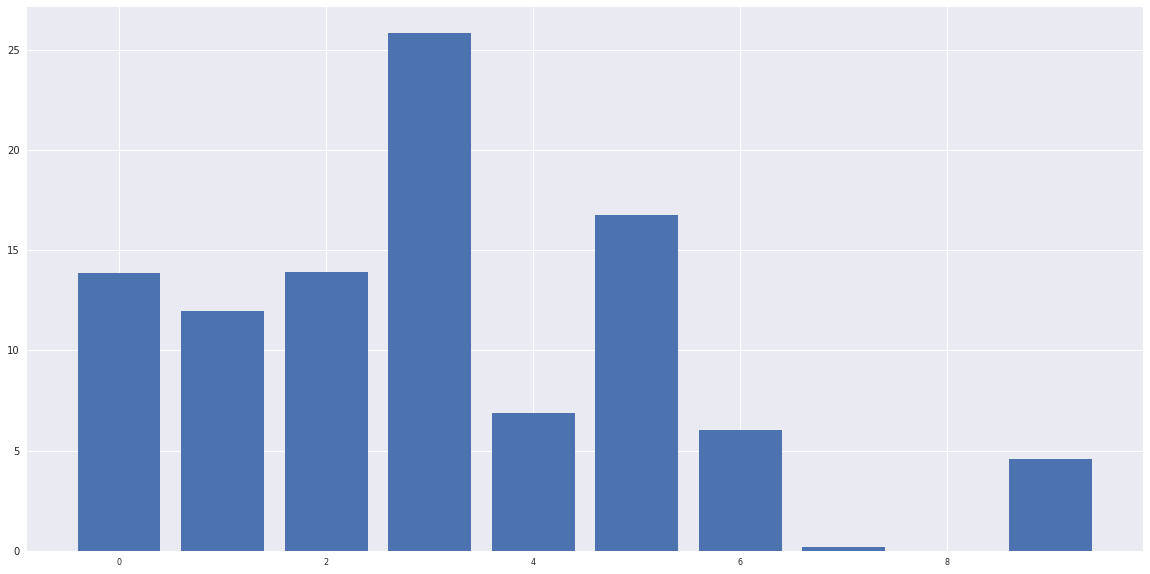

In [67]:
plt.bar(index_prop_customers,prop_customers)
plt.show()

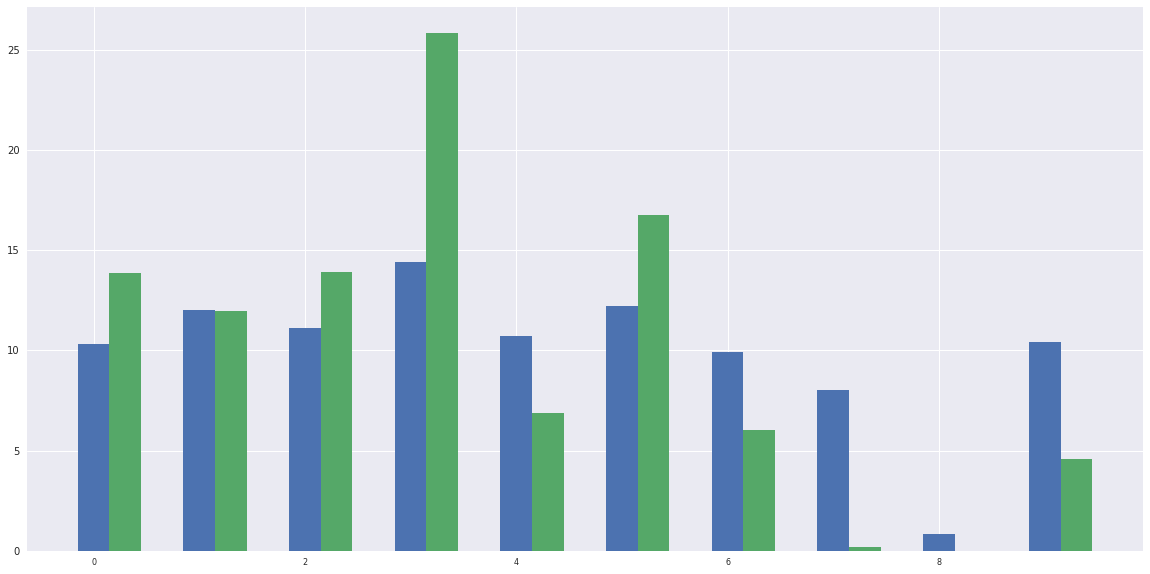

In [68]:
width =0.3
plt.bar(index_prop_dataset, prop_dataset, width=width)
plt.bar(index_prop_customers + width, prop_customers, width=width)
plt.show()

In [69]:
original_customer = scaler.inverse_transform(pca_object.inverse_transform(reduced_cleaned_customers))
print(original_customer[0:10])

[[  4.15372032e+00   4.78066340e+00   9.90821163e-01   4.99193003e+00
    1.05211511e+00   1.67554108e+00   2.68466674e+00   9.97554417e-01
    4.11671855e+00   4.78275946e+00   4.28162251e+00   2.83542654e+00
    3.80964174e+00   6.63151708e+00   6.78099938e+00   5.07126158e+00
    4.06102243e+00   1.79619722e+00   2.78589382e+00   2.47518625e+00
    2.19799470e+00   2.08620113e+00   2.03880375e+00   1.73889785e+00
    7.83634227e-04   2.82100266e+00   5.47681561e+00   8.59500551e+00
    1.97358572e+00  -9.22747938e-03   3.58380409e+00   1.99329904e+03
    2.53163318e+00   1.29857111e+00   2.39385424e-01   4.03846545e-02
    1.37629465e+00   3.95344695e+00   3.40679626e+00   4.46696062e+00
    5.12965993e+00   3.67828815e+00   2.60380387e+00   3.16663399e+00
    2.76824169e+00   3.21326638e+00   7.99321827e+02   2.34328329e+00
    2.37449152e+00   1.00960858e+00   1.86781723e-01   3.59290627e+00
    3.23560237e+00   2.38746491e+00   4.56834501e+00   3.74218079e+00
    3.88999884e-01  

In [70]:
original_customer = pd.DataFrame(original_customer, columns =column_customers )

In [71]:
original_customer 

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,GEBAEUDETYP_8.0,OST_WEST_KZ_O,OST_WEST_KZ_W,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_AGE,PRAEGENDE_JUGENDJAHRE_MOVEMENT_0.0,PRAEGENDE_JUGENDJAHRE_MOVEMENT_1.0,CAMEO_INTL_2015_FIRST,CAMEO_INTL_2015_SECOND
0,4.153720,4.780663,0.990821,4.991930,1.052115,1.675541,2.684667,0.997554,4.116719,4.782759,...,0.082043,0.004867,0.995133,1.099802,-0.120736,50.505082,0.729256,0.234257,2.225512,3.630623
1,4.063433,4.065538,1.058298,4.978381,0.793227,1.710455,3.252035,2.139610,4.354374,3.395558,...,0.572614,-0.100939,1.100939,0.018414,0.977506,53.040833,0.525485,0.460792,2.253920,3.604340
2,3.574011,4.654780,1.159105,4.688664,1.259926,1.621267,2.698930,1.557332,4.120321,4.348746,...,-0.548477,0.081757,0.918243,0.891057,0.055025,54.422666,0.392259,0.553909,2.306952,3.069897
3,2.578362,3.158925,2.397163,3.935210,2.623298,2.658923,3.106476,2.611079,3.381548,4.389018,...,-0.003601,-0.087274,1.087274,0.130867,0.800418,73.325109,0.429716,0.546383,4.017015,1.924259
4,3.283178,4.539733,1.244345,4.868812,1.137435,1.662505,2.772914,2.510683,4.388178,5.114317,...,0.160700,0.027530,0.972470,-0.185949,1.171286,55.242662,0.774545,0.244799,2.526931,3.707319
5,3.667768,5.035664,0.915923,5.027091,1.091938,1.503872,2.295020,1.512482,4.363798,4.445130,...,0.086927,-0.001133,1.001133,0.858430,0.109672,50.454166,0.712675,0.278244,1.965221,3.771422
6,4.069394,4.841765,0.962251,5.013114,0.709944,1.693763,2.564067,1.061654,4.282718,5.027534,...,0.068643,-0.031576,1.031576,1.073417,-0.083536,50.716503,0.766037,0.224180,2.257610,3.631659
7,4.207066,3.124607,1.353502,4.765626,1.273286,1.883825,4.492758,1.852506,4.084056,3.364994,...,-0.118102,0.110828,0.889172,-0.114256,1.064322,53.110235,-0.000060,0.847481,2.647838,4.180227
8,3.156408,4.656488,1.936949,3.997175,2.188026,2.543399,1.100368,2.803852,3.373036,4.877747,...,0.107014,0.026703,0.973297,-0.053924,1.081610,71.175934,0.750140,0.308060,2.024711,3.189678
9,3.549738,4.491975,1.505833,4.429801,1.110696,2.579136,2.042615,1.197067,3.955166,4.733480,...,0.036441,-0.138506,1.138506,1.232735,-0.262419,59.316519,0.736188,0.230894,1.897368,3.429949


In [73]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# The Fourth Cluster (cluster 3) is overrepresented in the customer dataset compared to the general population.
# We are going to infer what kind of people are represented by this cluster using the principal component analysis 
print_component(pca_object, 3)

Most wieghted features for the component  3
                                    weight
GREEN_AVANTGARDE_0               -0.376464
PRAEGENDE_JUGENDJAHRE_MOVEMENT_1 -0.360453
KKK                              -0.199054
BALLRAUM                         -0.185720
INNENSTADT                       -0.181009
                                    weight
PLZ8_ANTG3                        0.103128
ORTSGR_KLS9                       0.216339
EWDICHTE                          0.223864
GREEN_AVANTGARDE_1                0.376464
PRAEGENDE_JUGENDJAHRE_MOVEMENT_0  0.376464


Looking at cluster 3, We can see that the Principal component increase when there is decrease in Non-Membership in environmental sustainability as part of youth and also Dominating movement of person's youth to Mainstream. While there is increase in the component with an increase in Membership of environmental sustainability as part of youth and and also Dominating movement of person's youth to Avantgarde.

In conclusion, the company should target people who are membership of enviromental sustainability as part of youth and also has dominating movement of person's youth to Avantgarde as this falls to company. The people in this cluster are target audience for the company.

In [75]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# The Eight Cluster (cluster 7) is underrepresented in the customer dataset compared to the general population.
# We are going to infer what kind of people are represented by this cluster using the principal component analysis
print_component(pca_object, 7)

Most wieghted features for the component  7
                  weight
SOHO_KZ_0.0    -0.705439
W_KEIT_KIND_HH -0.019061
OST_WEST_KZ_O  -0.019041
KBA05_ANTG2    -0.016849
VERS_TYP_2.0   -0.013456
                       weight
ANZ_HAUSHALTE_AKTIV  0.015536
KBA05_ANTG4          0.017478
OST_WEST_KZ_W        0.019041
ANZ_PERSONEN         0.024568
SOHO_KZ_1.0          0.705439


Looking at cluster 7, We can see that the Principal component increase when there is decrease in people with no small office/home office. While there is increase in the PC when there is an increase in people with small office/home office.

This cluster is underrepresented in in the customer dataset compared to the general population and this suggests that this  group of persons is outside of the target demographics.

### Discussion 3.3: Compare Customer Data to Demographics Data

From the analysis using the Kmeans Clustering, we can conclude that people who are membership of enviromental sustainability as part of youth and also has dominating movement youth to Avantgarde in their are popular in this company while people with no small office/home office are not popular in the company.

This conclusion should help the company with decision making when advertising or making sales pictches. They know the demographic of their target market and they should improve their existing products or create new products to suit what their target audience likes.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.